In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/25000-canadian-rental-housing-market-june-2024/rentfaster.csv


# 1. Enviorment build up

**1.1 Import helpful libraries**

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns

**1.2 Load and Show the data**

In [4]:
file_path = '../input/25000-canadian-rental-housing-market-june-2024/rentfaster.csv'
original_data = pd.read_csv(file_path)

print("Overview of the DataFrame, including data types and non-null counts: \n")
original_data.info()

Overview of the DataFrame, including data types and non-null counts: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15 

In [5]:
original_data.head()

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


**1.3 Build a simple model for the set up**
    
    **This model is not use for the final use, it only using for find the best model**

In [6]:
# drop the row that missing the target value, price
# Drop rows with missing values in the 'price' column
print(original_data.columns)

original_data.dropna(axis=0, subset=['price'], inplace=True)

# Separate the target variable
y = original_data.price


# Separate the features
X = original_data.drop(['price'], axis=1)

# split the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation set into separate train and validation sets (e.g., 75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

Index(['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude',
       'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'link',
       'furnishing', 'availability_date', 'smoking', 'cats', 'dogs'],
      dtype='object')


In [7]:
# function just for test the dataset score
def score_dataset(X_train, X_valid, y_train, y_valid,model_class=RandomForestRegressor):
    model = model_class()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# 2. Handle the Categorical Variables
1. Drop Categorical Variables
2. Ordinal Encoding
3. One-Hot Encoding

**2.1 Determine the number of categorical variables present and consider the impact of removing them entirely.**

In [8]:
# get columns with categorical variable
s = (X_train.dtypes == 'object')
print(f"Categorical variables, the True means Categorical, else otherwise:\n\n{s}\n")
object_cols = list(s[s].index)

print(f"The percentage of the Categorical variables over All variables: {round((len(object_cols) / len(original_data.columns)), 2)}\n\n")

# approach 1 drop categorical variablesb  
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_val.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_val))

Categorical variables, the True means Categorical, else otherwise:

rentfaster_id        False
city                  True
province              True
address               True
latitude             False
longitude            False
lease_term            True
type                  True
beds                  True
baths                 True
sq_feet               True
link                  True
furnishing            True
availability_date     True
smoking               True
cats                  True
dogs                  True
dtype: bool

The percentage of the Categorical variables over All variables: 0.78


MAE from Approach 1 (Drop categorical variables):
397.8909200757154


> Approximately 78% of the features are categorical variables, meaning that if we ignore all of them, only about 22% of the data would remain, rendering the training process meaningless. Therefore, we cannot simply drop all categorical variables. However, in future analysis, we may consider removing some less meaningful categorical columns to streamline the dataset.

**2.2 Find out the count of unique elements for each categorical column**

In [9]:
def get_unique_elements_per_column(original_data, object_cols):
    """
    Returns a dictionary with the count of unique elements for each categorical column.

    Parameters:
    - original_data: DataFrame containing the data.
    - object_cols: List of column names that are categorical.

    Returns:
    - A dictionary where keys are column names and values are the number of unique elements in each column.
    """

    # get the details of the unique element in each columns
    unique_number_of_categorical_list = list(map(lambda col: original_data[col].nunique(), object_cols))

    # present by dictionary
    unique_number_of_categorical_dict = dict(zip(object_cols,unique_number_of_categorical_list))
    return unique_number_of_categorical_dict
    
print(f"The unique element in each columns is: \n {get_unique_elements_per_column(original_data, object_cols)}")

The unique element in each columns is: 
 {'city': 269, 'province': 10, 'address': 8002, 'lease_term': 6, 'type': 15, 'beds': 11, 'baths': 17, 'sq_feet': 1896, 'link': 9615, 'furnishing': 4, 'availability_date': 132, 'smoking': 4, 'cats': 2, 'dogs': 2}


> 1. The addresses vary widely, so consider removing the entire column or just the street numbers.
> 2. Convert sq_feet to a numeric variable instead of treating it as categorical.
> 3. The link field is unnecessary, as it only provides information about one location.
> 4. Simplify availability_date to two categories, as specific dates aren't needed.
> 5. Certain data should be numeric rather than categorical. For example, fields like beds, baths, and square feet need to be converted to numeric values.

**2.3.1 Remove the address number**

In [10]:
original_copy = original_data.copy()

# 1. remove the address number
print(f"Before remove the address number:\n\n{original_copy.address.head()}\nnumber of unique: {original_copy.address.nunique()}\n\n")

# removing process
original_copy["address"] = list(map(lambda x: re.sub(r'^\d+\s+', '', str(x)), original_copy.address))
print(f"After remove the address number:\n\n{original_copy.address.head()}\nnumber of unique: {original_copy.address.nunique()}\n\n")


Before remove the address number:

0    69 Gateway Dr NE
1    69 Gateway Dr NE
2    69 Gateway Dr NE
3    69 Gateway Dr NE
4    69 Gateway Dr NE
Name: address, dtype: object
number of unique: 8002


After remove the address number:

0    Gateway Dr NE
1    Gateway Dr NE
2    Gateway Dr NE
3    Gateway Dr NE
4    Gateway Dr NE
Name: address, dtype: object
number of unique: 6155




> > ummm, still too many, we might need another way to deal with it, or just simply delete it

**2.3.5 Convert and Handel the numeric variables**

In [11]:
def get_unique_values(original_data, features):
    """
    Returns unique values for specified features in a DataFrame.

    Parameters:
    original_data: The DataFrame containing the data.
    features (list): A list of column names to find unique values for.

    Returns:
    dict: A dictionary with column names as keys and arrays of unique values as values.
    """
    
    unique_values = {}
    
    # get a 2d array, contains 3 features' unique value
    list_of_features_unique_value = list(map(lambda feature: original_data[feature].unique(), features))
    
    unique_values = dict(zip(features, list_of_features_unique_value))

    return unique_values

# Find out the unique_values for each features
unique_values = get_unique_values(original_data, ['baths', 'beds', 'sq_feet'])
for unique in unique_values:
    print(f"{unique}: {unique_values[unique]},\n{unique} has {len(unique_values[unique])} uniques\n")

# original_copy.baths = list(map(lambda x: float(x) if x != "none" else 0, original_copy.baths))

# original_copy['baths'] = pd.to_numeric(original_copy['baths'], errors='coerce')
# print(original_copy.baths)


baths: ['2.5' '1' '2' '1.5' '3.5' nan '4' '3' '5' 'none' '4.5' '7.5' '5.5' '6'
 '6.5' '7' '8' '0'],
baths has 18 uniques

beds: ['2 Beds' '3 Beds' 'Studio' '1 Bed' '5 Beds' '4 Beds' nan '6 Beds'
 'none Beds' '8 Beds' '7 Beds' '9 Beds'],
beds has 12 uniques

sq_feet: ['1403' '1496' '1180' ... '260' '286' '334'],
sq_feet has 1897 uniques



> Beds and baths are straightforward, and any NaN or None values should be converted to 0. However, since square feet has 1,897 unique entries and many contain strings, we need to handle it more carefully

***Data Cleaning and Conversion of 'Baths' Column***

In [12]:
# baths: ['2.5' '1' '2' '1.5' '3.5' nan '4' '3' '5' 'none' '4.5' '7.5' '5.5' '6'
 #'6.5' '7' '8' '0'],
    
def clean_column(column_name,  cleaning_function):
    """
    Cleans the specified column in the DataFrame by converting non-numeric values
    to floats and handle the nan or string entries

    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - column_name: The name of the column to clean.
    - cleaning_function: A function that defines how to clean each value.

    The function prints the number of missing values before and after processing,
    displays the cleaned data, and confirms whether the conversion was successful.
    """
    
    before_num_of_missing = original_data[column_name].isnull().sum()
    # cleaning process is going on here!
    cleaning_function(column_name) 
    
    after_num_of_missing = original_data[column_name].isnull().sum()

    # '''Print the number of missing values before and after the conversion'''
    print(f"The number of missing before handle: {before_num_of_missing}")
    print(f"The number of missing after handle: {after_num_of_missing}\n")
    print(f"Bath data after cleaning:\n{original_data[column_name]}\n")

    # Check if conversion was successful (no missing values and correct dtype)
    if original_data[column_name].dtype != 'object' and after_num_of_missing == 0:
        print("Baths converted successfully with 0 missing values")
    else:
        print("Baths conversion failed")

        
# Convert values: replace "none" and NaN with 0, convert others to float        
def baths_cleaning(column_name):
    original_data[column_name] = original_data[column_name].map(
        lambda x: float(x) if x != "none" and not pd.isna(x) else 0
    )

clean_column('baths', baths_cleaning)

The number of missing before handle: 134
The number of missing after handle: 0

Bath data after cleaning:
0        2.5
1        2.5
2        2.5
3        2.5
4        2.5
        ... 
25766    1.0
25767    1.0
25768    1.0
25769    1.0
25770    1.0
Name: baths, Length: 25771, dtype: float64

Baths converted successfully with 0 missing values


***Data Cleaning and Conversion of 'Beds' Column***

In [13]:
# beds: ['2 Beds' '3 Beds' 'Studio' '1 Bed' '5 Beds' '4 Beds' nan '6 Beds'
 #'none Beds' '8 Beds' '7 Beds' '9 Beds'],


## Cleans and converts the beds column to integers.
def beds_cleaning(column_name):
    
    # Covert string value to integer
    def get_num_of_bad(value):
        value = value.replace("Beds", "").replace("Bed", "").strip()
        return int(value)
    
    original_data[column_name] = original_data[column_name].map(
        # Replaces 'none Beds' and 'Studio' with 0.
        lambda x: get_num_of_bad(x) if x != "none Beds"and x != "Studio" and not pd.isna(x) else 0 
    )
    
clean_column('beds', beds_cleaning)

The number of missing before handle: 132
The number of missing after handle: 0

Bath data after cleaning:
0        2
1        3
2        2
3        2
4        2
        ..
25766    0
25767    3
25768    1
25769    0
25770    2
Name: beds, Length: 25771, dtype: int64

Baths converted successfully with 0 missing values


***Data Cleaning and Conversion of 'sq_feet' Column***

In [21]:
# sq_feet cleaning
'''['361 Sq. Ft.',
 '525 Sq. Ft.',
 '810 Sq. Ft.',
 '265 Sq. Ft.',
 '700 Sq. Ft.','''
series = original_data.sq_feet.copy()

series = series.astype(str)

# for index, value in enumerate(series):
#     print(value, index)
#     if index > 15:
#         break
    
print(series[1764])
def sq_feet_data_clean(value):
    value.replace(r'[a-zA-Z]', '', regex=True).str.strip()
series = series.str.replace(r'[a-zA-Z.~()/,]', '', regex=True).str.strip()

special_entries = []
for index, value in enumerate(series):
    if not value.replace(',', '').isnumeric() and value != "":
        special_entries.append((value, index))
special_entries

571 + 87


[('1500+', 64),
 ('2193 +', 99),
 ('1560+', 121),
 ('490-652', 597),
 ('2300+1000', 836),
 ('600+', 940),
 ('600+', 941),
 ('600+', 942),
 ('600+', 943),
 ('600+', 944),
 ('600+', 945),
 ('1300+', 1249),
 ('1322-', 1300),
 ('1800 + 900', 1422),
 ('800+', 1512),
 ('850+', 1538),
 ('1550-1750  ***', 1622),
 ('2000+', 1742),
 ('571 + 87', 1764),
 ('1500+', 1772),
 ('571 + 87', 1826),
 ('500-600', 1965),
 ('569+', 1991),
 ('569+', 2041),
 ('1891+1100', 2075),
 ('2600+1200', 2215),
 ('1100+1100', 2268),
 ('2150 + 950', 2382),
 ('470--560', 2413),
 ('900+', 2456),
 ('900+', 2461),
 ('556-572', 2743),
 ('729-750', 2745),
 ('556-674', 2748),
 ('729-730', 2749),
 ('2700+', 2785),
 ('630  78', 2875),
 ('1371+1141', 2922),
 ('1000+', 2964),
 ('1000+', 2979),
 ('500 +-', 2982),
 ('1035+455', 3041),
 ('550-650', 3054),
 ('1100   1100', 3061),
 ('+-800', 3082),
 ('1500 900  + 600', 3107),
 ('2347 1829  + 518', 3118),
 ('1200   & 1000', 3123),
 ('1000 + 300', 3229),
 ('1000 + 300', 3259),
 ('1300   3

In [15]:


# # Make copy to avoid changing original data 
# label_X_train = X_train.copy()
# label_X_valid = X_val.copy()

# # Apply ordinal encoder to each column with categorical data
# ordinal_encoder = OrdinalEncoder()
# label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
# label_X_valid[object_cols] = ordinal_encoder.transform(label_X_valid[object_cols])

# print("MAE from Approach 2 (Ordinal Encoding):") 
# print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

# 3. Handle the missing variables
1. Drop Columns with Missing Values¶
2. Imputation fills in the missing values with some number. In this case, we fill in the mean value along each column.
3. An Extension To Imputation

**3.1 Identify columns with missing values and calculate the details.**

In [16]:
def get_missing_value_details(dataframe):
    """
    Identify columns with missing values and calculate the details.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.

    Returns:
    dict: A dictionary where keys are column names with missing values,
          and values are tuples containing the count and percentage of missing values.
    """
    # Get columns that have missing values
    cols_with_null = [col for col in dataframe.columns if dataframe[col].isnull().any()]

    # Calculate the sum and percentage of missing values for each column
    sum_of_cols_with_null = list(
        map(
            lambda col: (
                dataframe[col].isnull().sum(),  # Total number of missing values in the column
                "{:.5f}%".format(dataframe[col].isnull().sum() / len(dataframe) * 100)  # Percentage of missing values
            ),
            cols_with_null
        )
    )

    # Combine the column names with their respective missing value details into a dictionary
    combined_missing_value_dict = dict(zip(cols_with_null, sum_of_cols_with_null))

    return combined_missing_value_dict


combined_missing_value_dict = get_missing_value_details(X_test)
print(f"Columns with missing values:\n{combined_missing_value_dict}")


Columns with missing values:
{'address': (28, '0.54316%'), 'lease_term': (9, '0.17459%'), 'beds': (25, '0.48497%'), 'baths': (25, '0.48497%'), 'sq_feet': (850, '16.48885%'), 'availability_date': (4, '0.07759%'), 'smoking': (553, '10.72745%'), 'cats': (31, '0.60136%'), 'dogs': (31, '0.60136%')}


> Since the column 'sq_feet' has the highest number of missing values at 850 cases, which is only 0.16489% of the entire dataset, removing the entire column is not advisable. Therefore, using imputation to handle these missing values would be a better approach


In [17]:
# try Impution to handle the missing value
imputer = SimpleImputer()
# handle_X_train = pd.DataFrame(imputer.fit_transform(X_train))
# handle_X_valid = pd.DataFrame(imputer.transform(X_val))

# check the dataset score after the imputer
print("MAE from Imputation:")
# print(score_dataset(handle_X_train, handle_X_valid, y_train, y_valid))

MAE from Imputation:


**3.2 Consider employing an alternative model to estimate the missing variable; for example, use the existing number of bedrooms and bathrooms to predict the square footage.**

**3.3 Try using mulit-imputation to handle the missing variable**

# 4. Visualize the data

array([[<Axes: title={'center': 'rentfaster_id'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'baths'}>]], dtype=object)

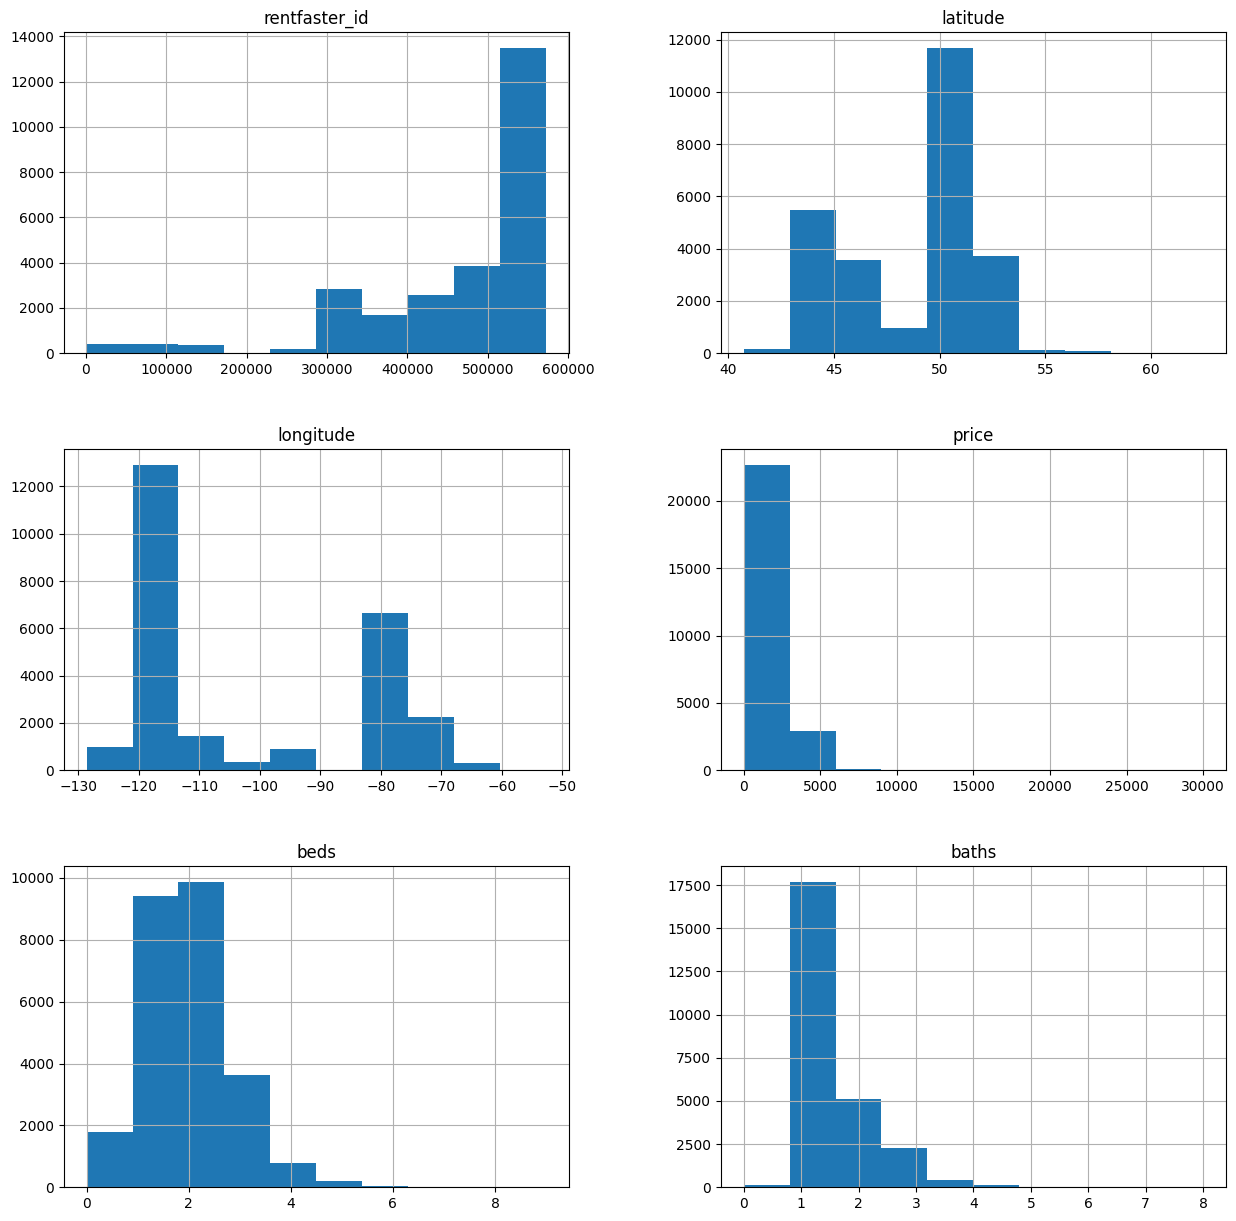

In [18]:
original_data.hist(figsize=(15, 15))